In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections, Machine

from PyHEADTAIL_feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL_feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL_feedback.processors.linear_transform import Averager
from PyHEADTAIL_feedback.processors.misc import Bypass
from PyHEADTAIL_feedback.processors.register import Register

np.random.seed(0)

PyHEADTAIL v(no git available to determine version)




In [2]:
""" 
    In this example, a feedback system consisting of multiple pickups and kickers is demonstrated. It differs
    very little from the previous example (002_separated_pickup_and_kicker), but it might look messy
    because multiple pickups and kickers must be initialized.   
"""

u' \n    In this example, a feedback system consisting of multiple pickups and kickers is demonstrated. It differs\n    very little from the previous example (002_separated_pickup_and_kicker), but it might look messy\n    because multiple pickups and kickers must be initialized.   \n'

In [3]:
# Basic parameters for the simulation
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3 

n_turns = 150

# Longitudinal motion of the bunch is not taken into account in this example.
machine = Machine(Q_s = 0.00000001)
# The longitudinal motion can be included to simulations by uncommenting the following line
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles,n_segments, 
                                                             n_slices,n_sigma_z)
bunch_unkicked = copy.deepcopy(bunch_ref)

In [4]:
# This creates an artificially kicked bunch, which will be damped with different feedback systems

slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

In [5]:
feedback_gain = 0.01
# feedback_gain = (0.01,0.01)

# Parameters for the registers
delay = 1 
n_values = 3

In [6]:
# This creates an artificially kicked bunch, which will be damped by using different feedback systems

bunch_OneBox_bunch = copy.deepcopy(bunch_ref)
tracker_OneBox_bunch = BunchTracker(bunch_OneBox_bunch)
slicer_OneBox_bunch = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]

# Because two kickers are used in this example, two times higher gain is used in this reference system
# which consists of one kicker
feedback_map = OneboxFeedback(2.*feedback_gain,slicer_OneBox_bunch,processors_bunch_x,processors_bunch_y)
total_map_OneBox_bunch = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_bunch,total_map_OneBox_bunch,tracker_OneBox_bunch)
# If you don't understand details of the code above, please study examples from 
# the file 001_ideal_feedbacks.ipynb

In [7]:
bunch_multi_object = copy.deepcopy(bunch_ref)
tracker_multi_object = BunchTracker(bunch_multi_object)
slicer_multi_object = copy.deepcopy(slicer_ref)

In [8]:
# Three pickups are initialized in this cell. The exactly same code as in the previous example
# (002_separated_pickup_and_kicker.ipynb) is also used in this example

# In this example, it is chosen that the pickups are located after the first, second and third segments of the trans_map.
# Trans_map is divded into a number of segments determined in the variable 'n_segments'

##############
## Pickup 1 ##
##############
pickup1_beta_x = machine.beta_x_inj
pickup1_beta_y = machine.beta_y_inj
pickup1_location_x = 1.*2.*pi/float(n_segments)*machine.Q_x
pickup1_location_y = 1.*2.*pi/float(n_segments)*machine.Q_y

pickup1_processors_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
pickup1_processors_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

pickup1_map = PickUp(slicer_multi_object,
                     pickup1_processors_x,pickup1_processors_y, 
                     pickup1_location_x, pickup1_beta_x,
                     pickup1_location_y, pickup1_beta_y)

##############
## Pickup 2 ##
##############
pickup2_beta_x = machine.beta_x_inj
pickup2_beta_y = machine.beta_y_inj
pickup2_location_x = 2.*2.*pi/float(n_segments)*machine.Q_x
pickup2_location_y = 2.*2.*pi/float(n_segments)*machine.Q_y

pickup2_processors_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
pickup2_processors_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

pickup2_map = PickUp(slicer_multi_object,
                     pickup2_processors_x,pickup2_processors_y, 
                     pickup2_location_x, pickup2_beta_x,
                     pickup2_location_y, pickup2_beta_y)

##############
## Pickup 3 ##
##############
pickup3_beta_x = machine.beta_x_inj
pickup3_beta_y = machine.beta_y_inj
pickup3_location_x = 3.*2.*pi/float(n_segments)*machine.Q_x
pickup3_location_y = 3.*2.*pi/float(n_segments)*machine.Q_y

pickup3_processors_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
pickup3_processors_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

pickup3_map = PickUp(slicer_multi_object,
                     pickup3_processors_x, pickup3_processors_y, 
                     pickup3_location_x, pickup3_beta_x,
                     pickup3_location_y, pickup3_beta_y)

In [9]:
# Two kickers are initialized in this cell. The exactly same code as in the previous example
# (002_separated_pickup_and_kicker.ipynb) is also used in this example. The only difference is that references for
# multiple register are given as an input parameter.
#
# In this example, it is chosen that the pickups are located after the first, second and fourth segment of the trans_map.
# Furthermore, it was chosen that Kicker 1 utilizes signals from pickups 1 and 2 and Kicker 2 utilizes signals from 
# the pickups 1 and 3.

##############
## Kicker 1 ##
##############
kicker1_processors_x = [Bypass()]
kicker1_processors_y = [Bypass()]

kicker1_beta_x = machine.beta_x_inj
kicker1_beta_y = machine.beta_y_inj
kicker1_location_x = 2.*2.*pi/float(n_segments)*machine.Q_x
kicker1_location_y = 2.*2.*pi/float(n_segments)*machine.Q_y

kicker1_registers_x = [
    pickup1_processors_x[-1],
    pickup2_processors_x[-1]
]
kicker1_registers_y = [
    pickup1_processors_y[-1],
    pickup2_processors_y[-1]
]

kicker1_map = Kicker(feedback_gain, slicer_multi_object, 
                     kicker1_processors_x, kicker1_processors_y,
                     kicker1_registers_x, kicker1_registers_y,
                     kicker1_location_x, kicker1_beta_x,
                     kicker1_location_y, kicker1_beta_y)

##############
## Kicker 2 ##
##############
kicker2_processors_x = [Bypass()]
kicker2_processors_y = [Bypass()]

kicker2_beta_x = machine.beta_x_inj
kicker2_beta_y = machine.beta_y_inj
kicker2_location_x = 4.*2.*pi/float(n_segments)*machine.Q_x
kicker2_location_y = 4.*2.*pi/float(n_segments)*machine.Q_y

kicker2_registers_x = [
    pickup2_processors_x[-1],
    pickup3_processors_x[-1]
]
kicker2_registers_y = [
    pickup2_processors_y[-1],
    pickup3_processors_y[-1]
]

kicker2_map = Kicker(feedback_gain, slicer_multi_object, 
                     kicker2_processors_x, kicker2_processors_y,
                     kicker2_registers_x, kicker2_registers_y,
                     kicker2_location_x, kicker2_beta_x,
                     kicker2_location_y, kicker2_beta_y)

In [10]:
# After that the maps of the pickups and the kickers must be added to correct slots of the total map 
# determined by the locations of the picups and the kickers
total_map_multi_object = [trans_map[0]] + [pickup1_map] + [trans_map[1]] + [pickup2_map] + [kicker1_map] + [trans_map[2]]+ [pickup3_map] + [trans_map[3]] + [kicker2_map]
for element in trans_map[4:]:
    total_map_multi_object += [element]
total_map_multi_object += [long_map]
    
track(n_turns, bunch_multi_object,total_map_multi_object,tracker_multi_object)

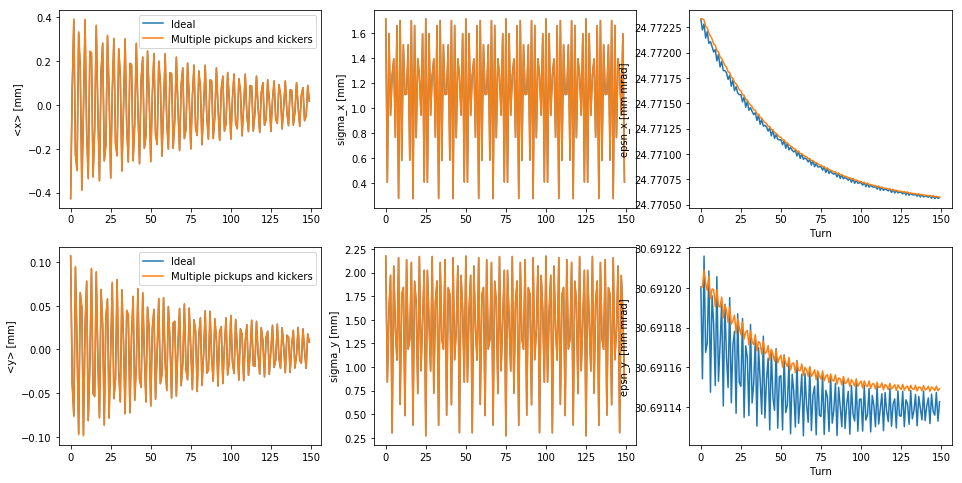

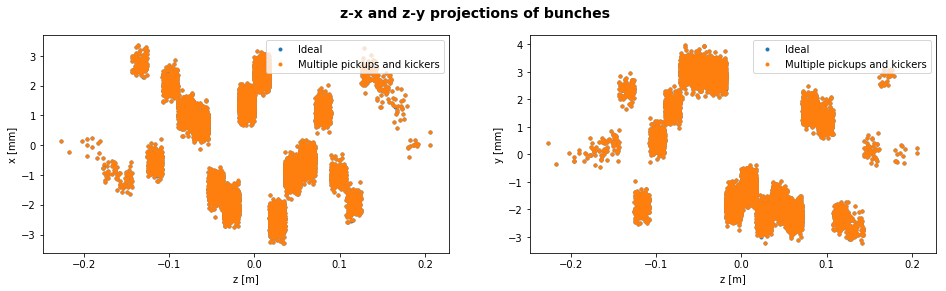

In [11]:
# In here, the traces and the projections from different implementations of the feedback system are compared.
# Note the scale in the emittance figures.

compare_traces([tracker_OneBox_bunch,tracker_multi_object],
               ['Ideal', 'Multiple pickups and kickers'])
compare_projections([ bunch_OneBox_bunch,  bunch_multi_object], 
                    ['Ideal', 'Multiple pickups and kickers'])

Jani Komppula, CERN, 2017